In [1]:
!rm ../data/dataset.csv
!cat ../data/en/hasoc2019/hasoc2019.csv >> ../data/dataset.csv
!cat ../data/en/hate_speech_icwsm18/nhsm.csv >> ../data/dataset.csv
!cat ../data/en/hate-speech-and-offensive-language/t_davidson.csv >> ../data/dataset.csv
!cat ../data/en/ousidhoum-etal-multilingual-hate-speech-2019/ousidhoum.csv >> ../data/dataset.csv
!cat ../data/en/semeval2019/semeval2019.csv >> ../data/dataset.csv

!rm ../data/dataset-hi.csv
!rm ../data/dataset-hi-cdmx.csv
!cat ../data/hi/hasoc2019/hi-hasoc2019.csv >> ../data/dataset-hi.csv
!cat ../data/hi/Hinglish-Offensive-Text-Classification/hi-code-mixed-pmathur.csv >> ../data/dataset-hi-cdmx.csv

In [2]:
# !pip install matplotlib
# !pip install ekphrasis
# !pip install seaborn
# !pip install joblib

In [ ]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import feature_generation as fg
import base_line_LR as lr
from utils.emoji import emoji_clean
import warnings
warnings.filterwarnings('ignore')
import pickle

## English Dataset

In [2]:
pre = fg.features(lang='en')
df_en = pd.read_csv('../data/dataset.csv')
df_en = df_en.dropna()
df_en.drop(df_en[(df_en['text_id'] == 'text_id')].index,inplace=True)
df_en.drop(df_en[(df_en['hate'] == 'HS')].index,inplace=True)
df_en.rename(columns={'hate':'class'},inplace=True)
df_en["class"] = df_en["class"].astype(int)
df_en['text_len'] = df_en.apply(lambda x: len(x.text.split()), axis=1)
df_en = df_en[df_en['text_len']<200]
print(df_en.shape)
print(df_en.describe())

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
(50379, 4)
              class      text_len
count  50379.000000  50379.000000
mean       1.122134     16.847476
std        0.878632     10.154718
min        0.000000      1.000000
25%        0.000000      9.000000
50%        1.000000     15.000000
75%        2.000000     22.000000
max        2.000000     95.000000


Size of dataset: 50379
Hateful (class) = 1: 10736 ( 21.310466662696758 %)
Offensive (class) = 2: 22898 ( 45.45147779828897 %)

****

**Hateful examples (class) = 1
["A gangster sets out to fulfill his father’s dream of becoming a doctor.    Doctor's in #WestBengal be like #munna_bhai_MBBS    #DoctorsFightBack #DoctorsStrike #DoctorsUnderOppression   @MamataOfficial https://t.co/lZQcStQ2Md"]

**Offensive examples (class) = 2
['!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!']


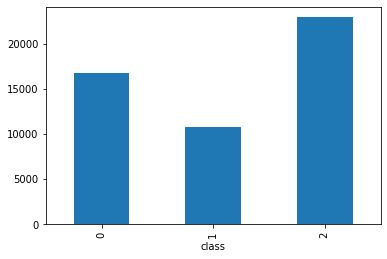

In [5]:
total = df_en.shape[0]
gp = df_en.groupby(['class'])['text_id'].count()
hate = gp[1]
offensive = gp[2]
print("Size of dataset:", total)
print("Hateful (class) = 1:", hate, "(",hate/total*100,"%)")
print("Offensive (class) = 2:",offensive, "(",offensive/total*100,"%)")
print("\n****\n")
print('**Hateful examples (class) = 1')
print(list(df_en[df_en['class']==1]['text'][0:1]))

print('\n**Offensive examples (class) = 2')
print(list(df_en[df_en['class']==2]['text'][0:1]))
gp.plot(kind='bar')


### Pre process text

In [2]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.dicts.noslang.slang import slang

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons,slang]
)


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [7]:
df_en['ekphrasis_clean_text'] = df_en.apply(lambda x: " ".join(text_processor.pre_process_doc(x.text)),axis=1)
df_en['basic_clean_text'] = df_en.apply(lambda x: pre.preprocess(x.text), axis = 1)
df_en.to_csv('../data/dataset_en.csv',index=False)

In [8]:
print(df_en['text'][100])
print(df_en['ekphrasis_clean_text'][100])

Why the #DoctorsFightBack is not just about violence unleashed on them ? Its time to address faltering justice systems, crippled health systems and broken dreams  https://t.co/S2akvvDDlY
why the <hashtag> doctors fight back </hashtag> is not just about violence unleashed on them ? its time to address faltering justice systems , crippled health systems and broken dreams <url>


In [9]:
print(df_en['text'][100])
print(df_en['basic_clean_text'][100])

Why the #DoctorsFightBack is not just about violence unleashed on them ? Its time to address faltering justice systems, crippled health systems and broken dreams  https://t.co/S2akvvDDlY
why the doctors fight back not just about violence unleashed them ? its time address faltering justice systems , crippled health systems and broken dreams


## Hindi Dataset

In [6]:
pre = fg.features(lang='hi')
df_hi = pd.read_csv('../data/dataset-hi.csv')
print(df_hi.shape)
df_hi.drop(df_hi[(df_hi['text_id'] == 'text_id')].index,inplace=True)
df_hi.drop(df_hi[(df_hi['hate'] == 'HS')].index,inplace=True)
df_hi.rename(columns={'hate':'class'},inplace=True)
print(df_hi.describe())

Reading english - 1grams ...
(9330, 3)
            class
count  9330.00000
mean      0.52926
std       0.49917
min       0.00000
25%       0.00000
50%       1.00000
75%       1.00000
max       1.00000


In [3]:
total = df_hi.shape[0]
gp = df_hi.groupby(['class'])['text_id'].count()
hate = gp[1]
print("Size of dataset:", total)
print("Hateful (class) = 1:", hate, "(",hate/total*100,"%)")
print("\n****\n")
print('**Hateful examples (class) = 1')
print(list(df_hi[df_hi['class']==1]['text'][0:1]))

Size of dataset: 9330
Hateful (class) = 1: 4938 ( 52.926045016077175 %)

****

**Hateful examples (class) = 1
['ये लिटन की गाँड में लिप्टन की चाय डालता हूँ अभी विथ गर्म केतली ']


In [4]:
df_hi['text'] = df_hi.apply(lambda x: emoji_clean(x.text), axis=1) 

In [ ]:
df_hi['ekphrasis_clean_text'] = df_hi.apply(lambda x: " ".join(text_processor.pre_process_doc(x.text)),axis=1)
df_hi['basic_clean_text'] = df_hi.apply(lambda x: pre.preprocess(x.text), axis = 1)
df_hi.to_csv('../data/dataset_hi.csv',index=False)

In [ ]:
print(df_hi['text'][100])
print(df_hi['ekphrasis_clean_text'][100])

In [ ]:
print(df_hi['text'][100])
print(df_hi['basic_clean_text'][100])

## Code mixed Hindi 

In [3]:
pre = fg.features(lang='en')
df_hi_cdmx = pd.read_csv('../data/dataset-hi-cdmx.csv')
print(df_hi_cdmx.shape)
df_hi_cdmx.drop(df_hi_cdmx[(df_hi_cdmx['text_id'] == 'text_id')].index,inplace=True)
df_hi_cdmx.drop(df_hi_cdmx[(df_hi_cdmx['hate'] == 'HS')].index,inplace=True)
df_hi_cdmx.rename(columns={'hate':'class'},inplace=True)
print(df_hi_cdmx.describe())

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
(3189, 3)
             class
count  3189.000000
mean      1.201944
std       0.929772
min       0.000000
25%       0.000000
50%       2.000000
75%       2.000000
max       2.000000


In [6]:
total = df_hi_cdmx.shape[0]
gp = df_hi_cdmx.groupby(['class'])['text_id'].count()
hate = gp[1]
print("Size of dataset:", total)
print("Hateful (class) = 1:", hate, "(",hate/total*100,"%)")
print("\n****\n")
print('**Hateful examples (class) = 1')
print(list(df_hi_cdmx[df_hi_cdmx['class']==1]['text'][0:10]))
print('**Offensive examples (class) = 2')
print(list(df_hi_cdmx[df_hi_cdmx['class']==2]['text'][0:10]))
print('**Normal examples (class) = 0')
print(list(df_hi_cdmx[df_hi_cdmx['class']==0]['text'][0:10]))

Size of dataset: 3189
Hateful (class) = 1: 303 ( 9.501411100658514 %)

****

**Hateful examples (class) = 1
['@InviSibleSold @mabkhan86 @dridadahn Main jutt Punjabi hoon aur paka N league. Madarchod Imran ki Punjab say nafrat clear hai.', 'RT @AnshKSpeaks: Screw the law of the land. If I find this chutiya Madarchod Mulla I will Lynch him, murder him, cut into millions of pieces and Ha\\xe2\\x80\\xa6', "*Virat and Anushka's future kid*\\n\\nAnushka: Mamma bolo beta, mammaaaa\\n\\nKid: Mm.. Ma.. Maa.. Madarchod!", '@dasraghubar @narendramodi @AmitShah @BJP4India @BJPLive @BJP4Jharkhand Madarchod brahmno se mafi mango', '@NANGI_POOJA Madarchod musalman aaiysha aur wo hai', '@M_walim @ICC @imVkohli @AnushkaSharma Teri ammi ko chodne wala insaan hai ye icc kya pure world isko badhai dekha bc hat mulle madarchod', '@girishalva @garuna73 I never donate to any madarchod hindu priests, they are chors.', 'Bhak Machod Mullo Ke Abbu  @bewak_sanki543 @milkygaay @Dilli_Ka_Maalik @ArvindKrejriwal @as

In [5]:
df_hi_cdmx['text'] = df_hi_cdmx.apply(lambda x: emoji_clean(x.text), axis=1) 

df_hi_cdmx['ekphrasis_clean_text'] = df_hi_cdmx.apply(lambda x: " ".join(text_processor.pre_process_doc(x.text)),axis=1)
df_hi_cdmx['basic_clean_text'] = df_hi_cdmx.apply(lambda x: pre.preprocess(x.text), axis = 1)
df_hi_cdmx.to_csv('../data/dataset_hi_cdmx.csv',index=False)

In [7]:
print(df_hi_cdmx['text'][100])
df_hi_cdmx['basic_clean_text'][100]

@AvijitEmmi Bahenchod .... experienced lagte ho bhai bhot face with tears of joy


'user bahenchod  experienced lagte hold on bhai bhot face with tears joy'

In [8]:
print(df_hi_cdmx['text'][100])
print(df_hi_cdmx['ekphrasis_clean_text'][100])

@AvijitEmmi Bahenchod .... experienced lagte ho bhai bhot face with tears of joy
<user> bahenchod . <repeated> experienced lagte hold on bhai bhot face with tears of joy


In [9]:
print(df_hi_cdmx.loc[100,:])

class                                                                   2
text                    @AvijitEmmi Bahenchod .... experienced lagte h...
text_id                                                       pmathur_100
ekphrasis_clean_text    <user> bahenchod . <repeated> experienced lagt...
basic_clean_text        user bahenchod  experienced lagte hold on bhai...
Name: 100, dtype: object


## Building LR Baseline Model - EN

In [3]:
text = df_en.text
feat = fg.features(lang='en')
M,fnames,tfidf_vect,pos_vect = feat.get_feature_array(text)
pickle.dump(tfidf_vect, open('../model/en_tfidf_vect.plk', 'wb'))
pickle.dump(pos_vect, open('../model/en_pos_vect.plk', 'wb'))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


  0%|          | 0/50379 [00:00<?, ?it/s]

Reading twitter - 1grams ...
en


100%|██████████| 50379/50379 [00:35<00:00, 1428.15it/s]


Creating new TFIDF Vectorizer
Creating new POS Vectorizer


In [22]:
X = pd.DataFrame(M)
y = df_en['class'].astype(int)

In [23]:
logreg = lr.LR()
model = logreg.train(X,y,max_iter=5000, test_size=0.2,param_grid=[{}], path='../model/en_logistic_reg.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 120.6min finished


Writing Model to file
Done!


In [24]:
y_pred = logreg.predict(model)

In [25]:
report = logreg.gen_report(y_pred=y_pred)
print('Accuracy: ',report[0])
print(report[1])

Accuracy:  0.6875744342993251
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      3349
           1       0.45      0.49      0.47      2147
           2       0.81      0.79      0.80      4580

    accuracy                           0.69     10076
   macro avg       0.65      0.65      0.65     10076
weighted avg       0.69      0.69      0.69     10076



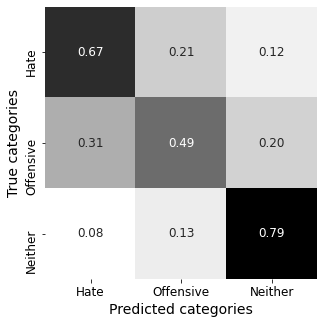

In [26]:
logreg.gen_confusion_matrix(y_pred = y_pred)

## Building LR Baseline Model - HI

In [8]:
text = df_hi.text
feat = fg.features(lang='hi')
M,fnames,tfidf_vect,pos_vect = feat.get_feature_array(text)
# pickle.dump(tfidf_vect, open('../model/hi_tfidf_vect.plk', 'wb'))
# pickle.dump(pos_vect, open('../model/hi_pos_vect.plk', 'wb'))

Reading english - 1grams ...


  0%|          | 0/9330 [00:00<?, ?it/s]

hi


100%|██████████| 9330/9330 [52:30<00:00,  2.96it/s]  


Creating new TFIDF Vectorizer
Creating new POS Vectorizer


In [9]:
X = pd.DataFrame(M)
y = df_hi['class'].astype(int)

In [10]:
logreg = lr.LR()
model = logreg.train(X,y,max_iter=5000, test_size=0.2,param_grid=[{}], path='../model/hi_logistic_reg.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Writing Model to file
Done!


In [11]:
y_pred = logreg.predict(model)

In [12]:
report = logreg.gen_report(y_pred=y_pred)
print('Accuracy: ',report[0])
print(report[1])


Accuracy:  0.9565916398713826
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       878
           1       0.95      0.96      0.96       988

    accuracy                           0.96      1866
   macro avg       0.96      0.96      0.96      1866
weighted avg       0.96      0.96      0.96      1866



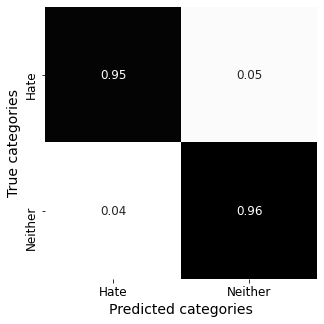

In [13]:
logreg.gen_confusion_matrix(y_pred = y_pred, classes = 2)

## Building LR Baseline Model - HI - Code Mix

In [10]:
text = df_hi_cdmx.text
feat = fg.features(lang='en')
M,fnames,tfidf_vect,pos_vect = feat.get_feature_array(text)
pickle.dump(tfidf_vect, open('../model/hi_cdmx_tfidf_vect.plk', 'wb'))
pickle.dump(pos_vect, open('../model/hi_cdmx_pos_vect.plk', 'wb'))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


  0%|          | 0/3189 [00:00<?, ?it/s]

Reading twitter - 1grams ...
en


100%|██████████| 3189/3189 [00:02<00:00, 1561.71it/s]


Creating new TFIDF Vectorizer
Creating new POS Vectorizer


In [11]:
X = pd.DataFrame(M)
y = df_hi_cdmx['class'].astype(int)

In [12]:
logreg = lr.LR()
model = logreg.train(X,y,max_iter=3000, test_size=0.2,param_grid=[{}], path='../model/hi_cdmx_logistic_reg.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Writing Model to file
Done!


In [13]:
y_pred = logreg.predict(model)

In [14]:
report = logreg.gen_report(y_pred=y_pred)
print('Accuracy: ',report[0])
print(report[1])

Accuracy:  0.8557993730407524
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       224
           1       0.59      0.66      0.62        61
           2       0.91      0.91      0.91       353

    accuracy                           0.86       638
   macro avg       0.78      0.80      0.79       638
weighted avg       0.86      0.86      0.86       638



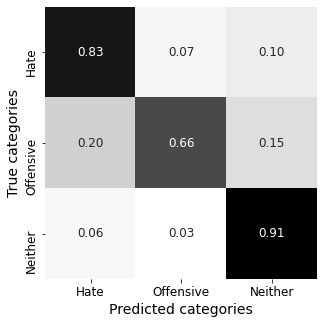

In [15]:
logreg.gen_confusion_matrix(y_pred = y_pred, classes=3)

## test Case

In [16]:
text = '@AvijitEmmi Bahenchod .... experienced lagte ho bhai bhot face with tears of joy'
feat = fg.features(lang='en')
tfidf_vect = pickle.load(open('../model/hi_cdmx_tfidf_vect.plk', 'rb'))
pos_vect = pickle.load(open('../model/hi_cdmx_pos_vect.plk', 'rb'))
M,fnames,_,_ = feat.get_feature_array([text],tfidf_vect,pos_vect)
path='../model/hi_cdmx_logistic_reg.pkl'
logreg = lr.LR()
model = logreg.load_model(path)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]

en
Loading Model from file


In [17]:
y_pred = logreg.predict(model,X_test=M)

In [ ]:
y_pred